In [1]:
import math
import numpy as np
import sys
import tensorflow as tf

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
word_embedding_size = 32

# 第一层的encoder RNN cell 的 hidden_state_size
encoder_hidden_units = 50

import helpers as data_helpers
batch_size = 11

# 一个generator，每次产生一个minibatch的随机样本
max_len = 8

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

### 一个简单的合成任务
一个query sequence和一个answer sequence，判断answer是不是query的反向copy

In [4]:
print('demo: query sequence')
data_q = next(batches)
data_q[:6]

demo: query sequence


[[9, 2, 7, 8, 3, 7],
 [3, 7, 6, 8, 2, 6, 3],
 [5, 3, 2, 4, 8],
 [3, 5, 4, 3, 5],
 [4, 3, 6, 3],
 [6, 3, 4, 4, 6, 5]]

In [5]:
print('demo: answer sequence')
data_a = data_q
for i in range(0, len(data_q), 2):
    data_a[i] = data_a[i][::-1]
data_a[:6]

demo: answer sequence


[[7, 3, 8, 7, 2, 9],
 [3, 7, 6, 8, 2, 6, 3],
 [8, 4, 2, 3, 5],
 [3, 5, 4, 3, 5],
 [3, 6, 3, 4],
 [6, 3, 4, 4, 6, 5]]

In [163]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [164]:
with tf.name_scope('minibatch_query'):
    query_input = tf.placeholder(shape=(None, max_len),
                           dtype=tf.int32,
                           name='encoder_query')
    query_length = tf.placeholder(shape=(None,),
                                  dtype=tf.int32,
                                  name='encoder_query_length')

with tf.name_scope('minibatch_answer'):
    answer_input = tf.placeholder(shape=(None, max_len),
                            dtype=tf.int32,
                            name='encoder_answer')
    answer_length = tf.placeholder(shape=(None,),
                                   dtype=tf.int32,
                                   name='encoder_answer_length')

with tf.name_scope('minibatch_label'):
    true_labels = tf.placeholder(shape=(None,), 
                            dtype=tf.float32, 
                            name='labels')
    
    
with tf.name_scope('embedding'):
    word_embeddings = tf.Variable(
        tf.random_uniform([vocab_size, word_embedding_size], -1.0, 1.0),
        dtype=tf.float32)

with tf.name_scope('embedding_input'):
    query_embedded = tf.nn.embedding_lookup(
        word_embeddings, query_input)
    answer_embedded = tf.nn.embedding_lookup(
        word_embeddings, answer_input)

In [165]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

query_outputs, query_final_state = tf.nn.dynamic_rnn(
    encoder_cell, query_embedded,
    dtype=tf.float32
)

answer_outputs, answer_final_state = tf.nn.dynamic_rnn(
    encoder_cell, answer_embedded,
    dtype=tf.float32
)

In [166]:
attention_embed_size = 16

def get_attention(q_vec, fact_vec, reuse):
    """Use question vector and previous memory to create scalar attention for current fact
    Args:
        q_vec: [batch_size, hidden_size]
        fact_vec: [batch_size, hidden_size]
    """
    with tf.variable_scope("attention", reuse=reuse):

        attention = tf.layers.dense(
            tf.concat(values = [q_vec, fact_vec], axis =1),
            attention_embed_size,
            activation=tf.nn.tanh)

        attention = tf.layers.dense(attention,
                1,
                activation=None)
        
    return attention

In [167]:
attentions = [tf.squeeze(
    get_attention(query_final_state.h, fv, bool(i)), axis=1)
    for i, fv in enumerate(tf.unstack(answer_outputs, axis=1))]

attentions = tf.transpose(tf.stack(attentions))
attentions = tf.nn.softmax(attentions)

answer_states = tf.reduce_sum(
    input_tensor = tf.multiply(tf.expand_dims(attentions, axis=-1), answer_outputs), 
    axis = 1)

In [168]:
"""
logits = tf.layers.dense(
    tf.abs(query_input - answer_input),
    1, activation=None,
    name='prediction')
"""

logits = tf.layers.dense(
    tf.abs(query_final_state.h - answer_states),#tf.concat([query_final_state.h, answer_states],axis = -1), 
    16, activation=None,
    name='prediction')

"""
logits = tf.layers.dense(
    query_final_state.h - answer_final_state.h,
    16, activation=None,
    name='prediction')
"""
logits = tf.layers.dense(
    logits,
    1, activation=None,
    name='prediction-final')

loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits = tf.squeeze(logits),
        labels = true_labels) )


train_op = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(loss)

In [169]:
sess.run(tf.global_variables_initializer())

In [170]:
def next_feed():
    data_q = next(batches)
    labels_ = [0]*len(data_q)
    data_a = []
    for i in range(0, len(data_q)):
        if i%2:
            data_a.append(data_q[i][::-1])
            labels_[i] = 1
        else:
            data_a.append(data_q[i][:])
        
        
    data_q[0] = data_q[0] + [0]*(max_len-len(data_q[0]))
    data_a[0] = data_a[0] + [0]*(max_len-len(data_a[0]))
    
    query_, query_length_ = data_helpers.batch(data_q)
    answer_, answer_length_ = data_helpers.batch(data_a)
    # 在feedDict里面，key可以是一个Tensor
    return {
        query_input: query_.T,
        answer_input: answer_.T,
        query_length: query_length_,
        answer_length: answer_length_,
        true_labels: np.array(labels_)
    }

In [171]:
fd = next_feed()
fd

{<tf.Tensor 'minibatch_query/encoder_query:0' shape=(?, 8) dtype=int32>: array([[5, 3, 8, 2, 0, 0, 0, 0],
        [4, 6, 9, 5, 7, 4, 0, 0],
        [9, 7, 8, 4, 0, 0, 0, 0],
        [5, 8, 6, 6, 8, 8, 5, 3],
        [6, 6, 8, 7, 7, 3, 3, 7],
        [9, 8, 5, 9, 2, 8, 2, 2],
        [8, 8, 7, 0, 0, 0, 0, 0],
        [4, 6, 6, 6, 7, 3, 9, 0],
        [8, 6, 7, 2, 3, 0, 0, 0],
        [2, 2, 9, 2, 0, 0, 0, 0],
        [5, 5, 6, 3, 8, 2, 5, 3]], dtype=int32),
 <tf.Tensor 'minibatch_answer/encoder_answer:0' shape=(?, 8) dtype=int32>: array([[5, 3, 8, 2, 0, 0, 0, 0],
        [4, 7, 5, 9, 6, 4, 0, 0],
        [9, 7, 8, 4, 0, 0, 0, 0],
        [3, 5, 8, 8, 6, 6, 8, 5],
        [6, 6, 8, 7, 7, 3, 3, 7],
        [2, 2, 8, 2, 9, 5, 8, 9],
        [8, 8, 7, 0, 0, 0, 0, 0],
        [9, 3, 7, 6, 6, 6, 4, 0],
        [8, 6, 7, 2, 3, 0, 0, 0],
        [2, 9, 2, 2, 0, 0, 0, 0],
        [5, 5, 6, 3, 8, 2, 5, 3]], dtype=int32),
 <tf.Tensor 'minibatch_query/encoder_query_length:0' shape=(?,) dtype=int32>

In [172]:
loss_track = []
max_batches = 300

try:
    # 一个epoch的learning
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
except KeyboardInterrupt:
    print('training interrupted')

loss 0.0442 after 3300 examples (batch_size=11)


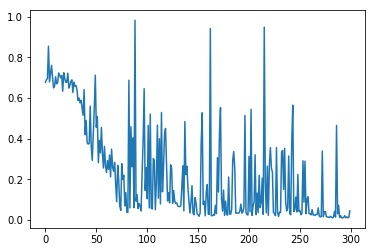

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [93]:
attentions2_.shape

(11, 8, 1)

In [94]:
answer_states_.shape

(11, 50)

In [17]:
attentions_

[array([[ 0.07015378,  0.08666528,  0.08810386,  0.09000389,  0.08408536,
          0.08797743,  0.09124135,  0.09652527,  0.09177346,  0.12077196,
          0.09269828],
        [ 0.06553879,  0.09167089,  0.0766434 ,  0.07932319,  0.08154513,
          0.09701919,  0.08512915,  0.10381684,  0.09236913,  0.12728807,
          0.09965625],
        [ 0.07173677,  0.09868125,  0.0856628 ,  0.09054205,  0.0751005 ,
          0.08830116,  0.07727864,  0.0988665 ,  0.10421292,  0.11148671,
          0.09813078],
        [ 0.07146949,  0.09468266,  0.08020807,  0.09434265,  0.07657301,
          0.09699043,  0.06939657,  0.10198721,  0.11032988,  0.11120375,
          0.09281622],
        [ 0.07346448,  0.09400321,  0.06882758,  0.09634233,  0.07795318,
          0.10402068,  0.07848771,  0.10455179,  0.10589755,  0.0982222 ,
          0.09822926],
        [ 0.07592437,  0.09201783,  0.07191911,  0.09597057,  0.06893051,
          0.10664532,  0.07122856,  0.10315593,  0.10996292,  0.1093378